In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def simGP(SN, irf, noise):

    length = (len(irf)-1)*2

    ts = np.zeros(length)
    ts[length//2] += 1

    ts_convolved = np.fft.irfft( (np.fft.rfft(ts) * irf) )
    psim = SN*ts_convolved + noise*np.random.normal(size=length)

    return psim

(4000, 5500)

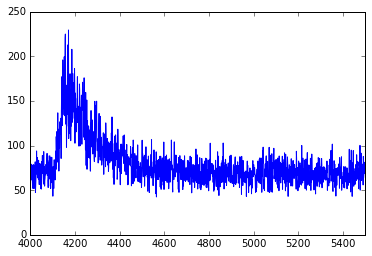

In [3]:
"""  Load Brightest Pulse """
p1 = np.load('ts2014-06-13T07:00:02.13597.npy')
p2 = np.load('ts2014-06-13T06:01:21.91125.npy')

data = p1.reshape(-1,4,6)
data = np.fft.rfft(data,axis=1)
plt.plot(abs(data).sum(1).sum(-1))
plt.xlim(4000,5500)

2.32586 4.38502
2.55447287128


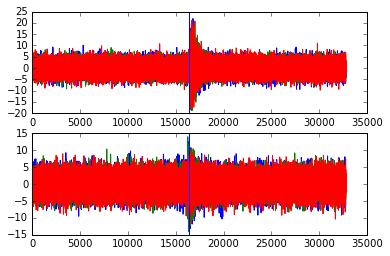

In [4]:
plt.subplot(211)
plt.plot(p1[:,1::2])
plt.axvline(2**14)

plt.subplot(212)
plt.plot(p2[:,1::2])
plt.axvline(2**14)

n_off = np.std(p1[:1024])
n_on  = np.std(p1[2**14:2**14+1024])

print n_off, n_on
print (n_on**2.0-n_off**2.0) / n_off**2.0

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


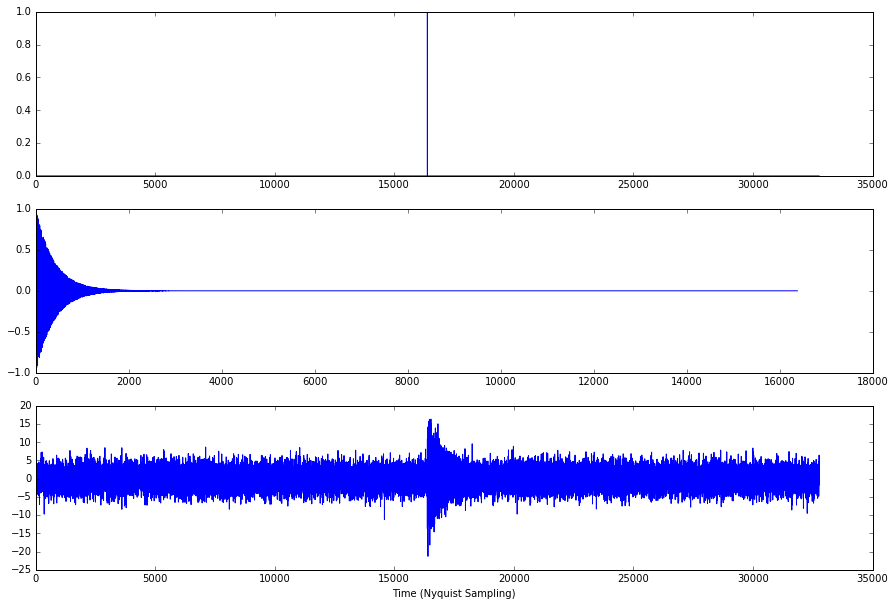

In [5]:
# Create exponential tail with 390 samples ~= 12.2microseconds
length = 2**15
t = np.arange(length)
#g = np.roll( np.exp(-t / 390.), length//2)
g = ( np.exp(-t / 390.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))

ts = np.zeros(length)
ts[length//2] += 1

plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(ts)

plt.subplot(312)
plt.plot(g)

irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

ts_convolved = np.fft.irfft( (np.fft.rfft(ts) * irf) )

SN1 = 12
SN2 = 10

psim1 = SN1*ts_convolved + n_off*np.random.randn(length)
psim2 = SN2*ts_convolved + n_off*np.random.randn(length)

plt.subplot(313)
plt.plot(psim1)
plt.xlabel('Time (Nyquist Sampling)')


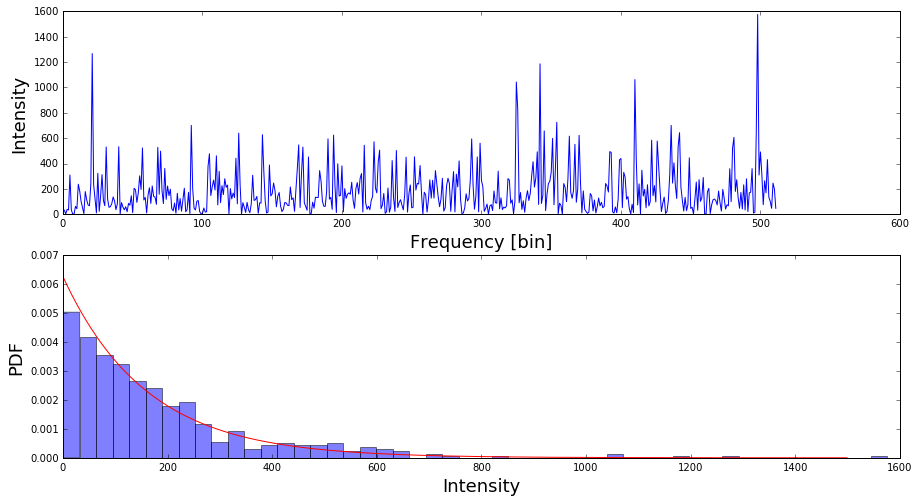

In [7]:
# Look at scintillations structure of simulated IRF
from scipy.stats import chi2

g_chan = np.fft.fft(g.reshape(-1,512), axis=1)


plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(np.abs(g_chan[0])**2.0)

plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Frequency [bin]', fontsize=18)

plt.subplot(212)
g_subbg = np.abs(g_chan[0])**2.0 - (np.abs(g_chan[1:])**2.0).mean(axis=0)
n, bins, patches = plt.hist(np.abs(g_subbg), 50, normed=True,  alpha=0.5)
plt.plot(chi2.pdf(np.arange(1500), 2, 0, 80), 'r')

plt.ylabel('PDF', fontsize=18)
plt.xlabel('Intensity', fontsize=18)

In [ ]:
""" Simulate many g(nu) to look at distribution """

nchan = 512
nstep = 10000
g_int = np.zeros(nchan*nstep)

for i in np.arange(nstep):
    g = ( np.exp(-t / 390.) + 0j )[:length//2]
    g *= np.exp(2j*np.pi*np.random.random(length//2))
    g_chan = np.fft.fft(g.reshape(-1,nchan), axis=1)
    g_subbg = np.abs(g_chan[0])**2.0 - (np.abs(g_chan[1:])**2.0).mean(axis=0)
    g_int[i*nchan:(i+1)*nchan] = g_subbg
    
n, bins, patches = plt.hist(np.abs(g_subbg), 64, normed=True,  alpha=0.5)
plt.plot(chi2.pdf(np.arange(1500), 2, 0, 80), 'r')

plt.ylabel('PDF', fontsize=18)
plt.xlabel('Intensity', fontsize=18)

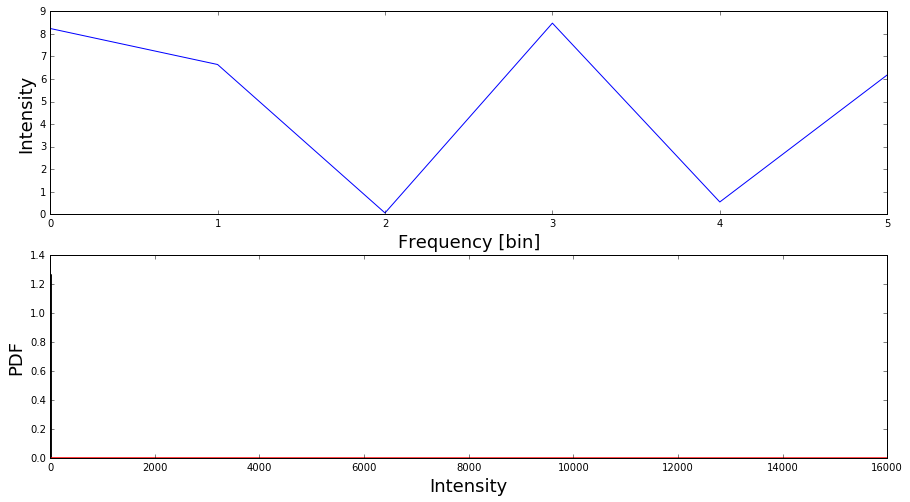

In [30]:
""" Look at distribution in real data """

p1_power = np.abs(p1)**2.0
p1_bgsub = p1_power - np.median(p1_power, axis=-1, keepdims=True)

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot((p1_power[50]))

plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Frequency [bin]', fontsize=18)

plt.subplot(212)

n, bins, patches = plt.hist(p1_power[50], 64, normed=True,  alpha=0.5)
plt.plot(chi2.pdf(np.arange(16000), 2, 0, 1250), 'r')

plt.ylabel('PDF', fontsize=18)
plt.xlabel('Intensity', fontsize=18)

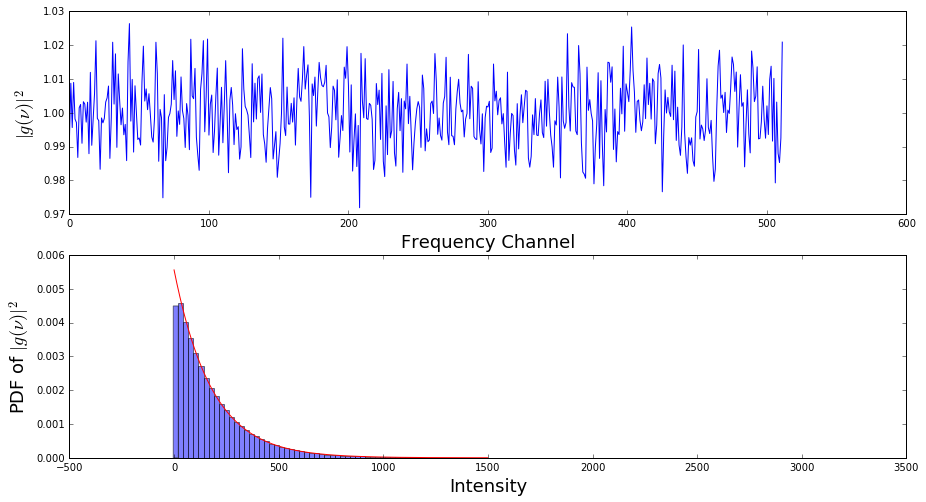

In [31]:
plt.figure(figsize=(15,8))

plt.subplot(211)
plt.ylabel(r'$|g(\nu)|^{2}$', fontsize=18)
plt.xlabel('Frequency Channel', fontsize=18)
g_rebin = g_int.reshape(nstep, nchan)
plt.plot(g_rebin.mean(axis=0) / np.mean(g_rebin.mean(axis=0)))

plt.subplot(212)

n, bins, patches = plt.hist(g_int, 128, normed=True,  alpha=0.5)
plt.plot(chi2.pdf(np.arange(1500), 2, 0, 90), 'r')

plt.ylabel(r'PDF of $|g(\nu)|^{2}$', fontsize=18)
plt.xlabel('Intensity', fontsize=18)

(-25, 25)

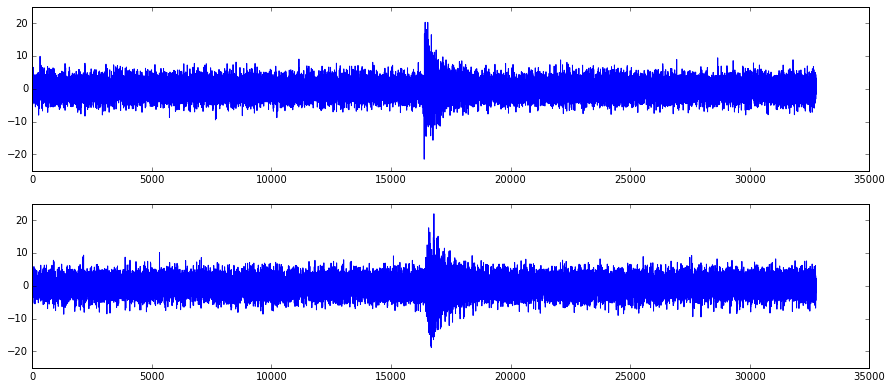

In [32]:
plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(psim1)
plt.ylim(-25, 25)

plt.subplot(312)
plt.plot(p1[:,1])
plt.ylim(-25, 25)

In [6]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_returnts(p1, p2, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = dechannelize(p12_phased)
    return p12_phased

def Stokes(R,L):
    I = abs(R)**2.0 + abs(L)**2.0
    Q = 2*np.real(np.conj(L)*R)
    U = -2*np.imag(np.conj(L)*R)
    V = abs(R)**2.0 - abs(L)**2.0
    return I, Q, U, V

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def pad(ts,nzeros):
    ts = np.concatenate((ts,0*ts[:nzeros]), axis=0)
    return ts

153600
1.4480863651
1.21527040405


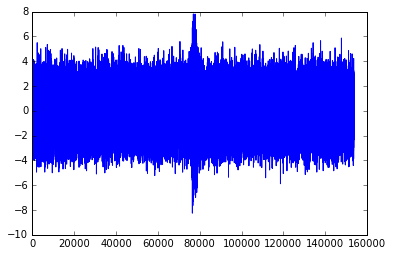

In [7]:
""" 
Compare to pipeline 

Pulses begin as shape (100, 768), with three 256 channel IFs combined

"""

""" Create Noise, SN values from real data """

nyq_pad = np.zeros((100,1))
p_comp = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T07:00:02.13597.npy')
p_comp = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:21.91125.npy')
#p_comp = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:23.83362.npy')
p_comp = np.concatenate((p_comp,nyq_pad), axis=1)

ts_comp = dechannelize(p_comp)
length = len(ts_comp)
print length
t = np.arange(length)
n_off = np.std(ts_comp[:40000])

plt.plot(ts_comp)

""" First, generate 3 impulse responses for the different IFs """
g = ( np.exp(-t / 390. / 3.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))
irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

SN = np.std(ts_comp[76000:76000+1024*3])**2.0 / np.std(ts_comp[:1024*3])**2.0 - 1
print SN
print np.sqrt(1+SN**(-2.0))

2.18322316107
1.34315111489
2.1505445304
1.37446938948


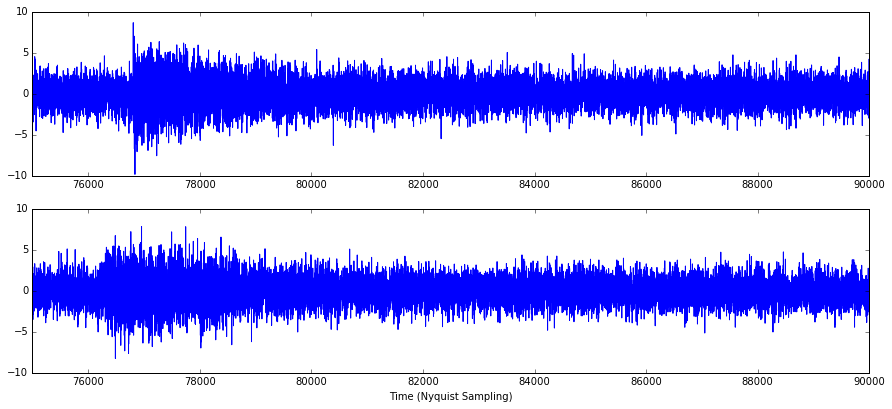

In [8]:
""" Generate two pulses with different SN but same IRF """

%matplotlib inline

p_irf = simGP(4, irf, n_off)

print(np.std(p_irf[76600:76600+1024*3]))
print(np.std(p_irf[:1024*3]))

print(np.std(ts_comp[76000:76000+1024*3]))
print(np.std(ts_comp[:1024*3]))

plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(p_irf)
plt.ylim(-10, 10)
plt.xlim(75000,90000)

plt.subplot(312)
plt.plot(ts_comp)
plt.ylim(-10, 10)
plt.xlim(75000,90000)

plt.xlabel('Time (Nyquist Sampling)')

In [9]:
""" De-Scattering Loop """

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

td = []
pratio = []

p_irf = simGP(4, irf, n_off)
p_irf = np.roll(p_irf, int(np.random.randn(1)*len(irf)) )
p1 = channelize_ts(p_irf, 256*3)
p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
p1temp = np.roll(rechannelize(p1,cchan), cratio*(514-np.argmax(p1prof)), axis=0)

for i in range(100):
    p2 = simGP(2.2, irf, n_off)
    p2 = np.roll(p2, int(np.random.randn(1)*len(irf)) )
    
    p2 = channelize_ts(p2, 256*3)
            
    p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
    p2temp = np.roll(rechannelize(p2,cchan), cratio*(514-np.argmax(p2prof)), axis=0)

    p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
    p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
    p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

    p11pcorr = (abs(p22pcorr)**2.0).sum(1)
    p22pcorr = (abs(p22pcorr)**2.0).sum(1)
            
    Npeak = p11pcorr.shape[0]*cchan/fchan
    p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
    p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
    corrnorm = 1.

    pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

    pauto = np.sqrt(p11max*p22max)

    pratio.append(pcross / pauto)

sim_pcorr = (np.abs(p12pcorr)**2.0).sum(1)
sim_p11pcorr = p11pcorr
sim_p22pcorr = p22pcorr
test_sim = p1temp
pr1 = 1*np.array(pratio)
print pr1

[ 0.60994844  0.66002497  0.54524545  0.65312207  0.47364277  0.52678422
  0.52054476  0.59577877  0.58943351  0.51544001  0.69296543  0.57823903
  0.61845556  0.61553643  0.4705895   0.53976613  0.59413684  0.58210486
  0.6902537   0.58066028  0.43559315  0.67060723  0.68102269  0.59570177
  0.6360411   0.53158759  0.55486032  0.5971642   0.63562626  0.70790364
  0.65117612  0.48900237  0.62642402  0.68754417  0.61219085  0.56476262
  0.60955603  0.53604301  0.6202523   0.54136588  0.53873438  0.70572355
  0.52762347  0.62574529  0.63844711  0.58966634  0.52510901  0.61480037
  0.70763493  0.53604356  0.57636863  0.65535538  0.58492808  0.62285823
  0.63875223  0.58678726  0.57706452  0.58020759  0.56891823  0.66322044
  0.62230765  0.61055548  0.36058172  0.60999421  0.6568465   0.69955937
  0.61527241  0.64003878  0.5755806   0.67594675  0.5735533   0.52154406
  0.63763688  0.62690277  0.55455615  0.6187752   0.59318988  0.43223153
  0.67244515  0.58434019  0.64564757  0.64375069  0

[0.50448485106614016]


(448, 640)

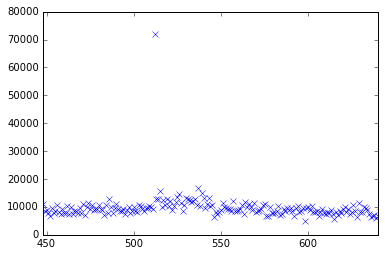

In [10]:
""" Real Example """

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

fig, ax1 = plt.subplots()

td = []
pratio = []

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:21.91125.npy')
p1 = np.concatenate((p1,nyq_pad), axis=1)

p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
p1temp = np.roll(rechannelize(p1,cchan), cratio*(519-np.argmax(p1prof)), axis=0)

p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:23.83362.npy')
p2 = np.concatenate((p2,nyq_pad), axis=1)
    
p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
p2temp = np.roll(rechannelize(p2,cchan), cratio*(520-np.argmax(p2prof)), axis=0)

p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

p11pcorr = (abs(p22pcorr)**2.0).sum(1)
p22pcorr = (abs(p22pcorr)**2.0).sum(1)
            
Npeak = p11pcorr.shape[0]*cchan/fchan
p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
corrnorm = 1.

pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

pauto = np.sqrt(p11max*p22max)
pratio.append(pcross / pauto)

real_pcorr = (np.abs(p12pcorr)**2.0).sum(1)
real_p11pcorr = p11pcorr
real_p22pcorr = p22pcorr

testreal = p1temp

print pratio

plt.plot((np.abs(p12pcorr)**2.0).sum(1), 'bx')

plt.xlim(512-64, 512+128)

0.597608238198 0.06510690186
1.67333703935


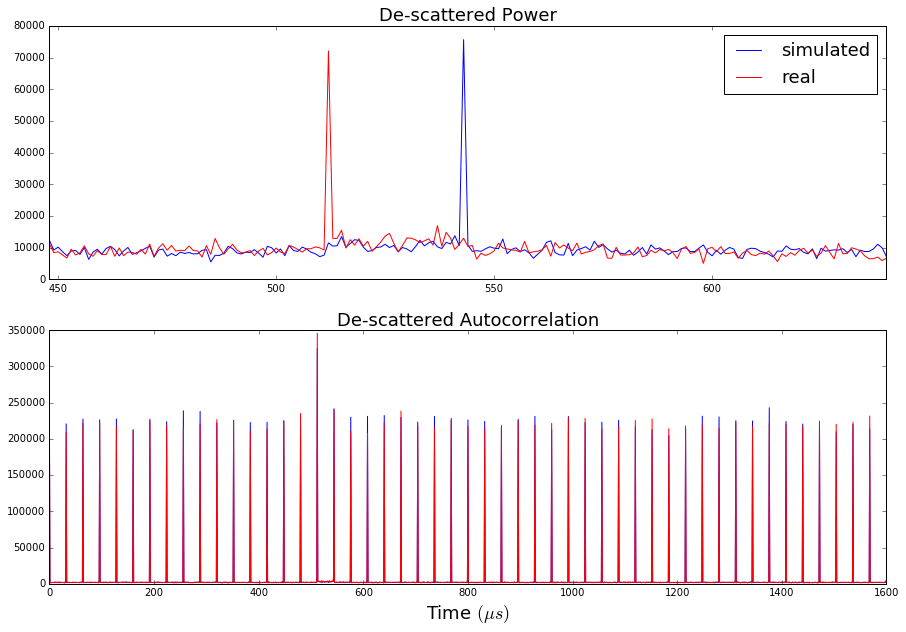

In [11]:
print np.mean(pr1), np.std(pr1)

sim = (np.abs(p12pcorr)**2.0).sum(1)

correction = 1 / np.mean(pr1)
print correction

plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(sim_pcorr, 'b-', label='simulated')
plt.plot(real_pcorr, 'r-', label='real')

plt.xlim(512-64,512+128)
#plt.xlabel(r'Time $(\mu s)$', fontsize=18)
plt.title('De-scattered Power', fontsize=18)
plt.legend(fontsize=18)

plt.subplot(212)
plt.title('De-scattered Autocorrelation', fontsize=18)
plt.plot(sim_p22pcorr, 'b-')
plt.plot(real_p22pcorr, 'r-')
plt.xlabel(r'Time $(\mu s)$', fontsize=18)


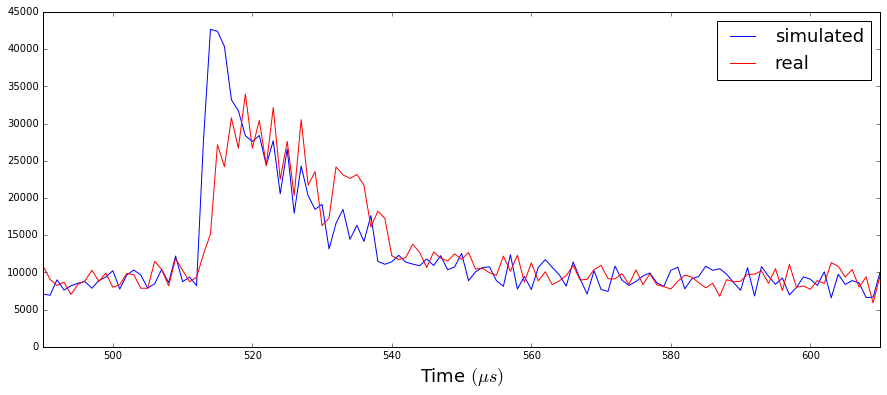

In [12]:

profreal = rechannelize(testreal, 16*3)
profsim = rechannelize(test_sim, 16*3)
#plt.xlim(75000,85000)


prof1 = (abs(profsim)**2.0).sum(1)
prof2 = (abs(profreal)**2.0).sum(1)
#SN = (prof - np.mean(prof[20:])) / np.std(prof[20:])

plt.figure(figsize=(15,6))
plt.plot(prof1, label='simulated')
plt.plot(prof2, 'r', label='real')

plt.xlim(490,610)
plt.xlabel(r'Time $(\mu s)$', fontsize=18)

plt.legend(fontsize=18)

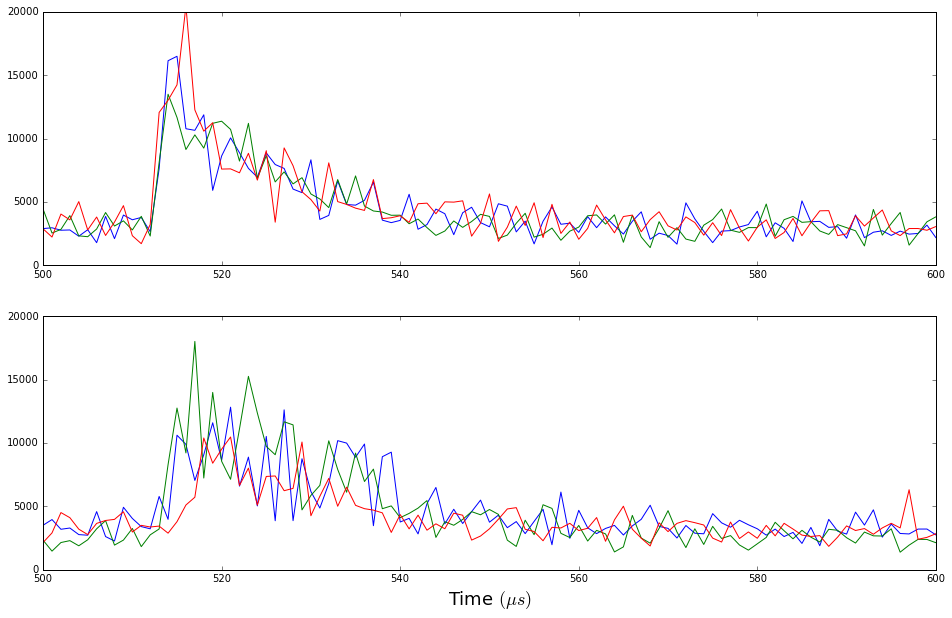

In [13]:
""" Check de-dispersion """

plt.figure(figsize=(16,10))

plt.subplot(211)
p = abs(profsim)**2.0
plt.plot(p[:,:16].sum(1))
plt.plot(p[:,16:32].sum(1))
plt.plot(p[:,32:].sum(1))
plt.xlim(500,600)
plt.ylim(0,20000)

plt.subplot(212)
p = abs(profreal)**2.0
plt.plot(p[:,:16].sum(1))
plt.plot(p[:,16:32].sum(1))
plt.plot(p[:,32:].sum(1))
plt.xlim(500,600)

plt.xlabel(r'Time $(\mu s)$', fontsize=18)

In [14]:
""" De-Scattering Loop to Determine SN corrections """

print length

g = ( np.exp(-t / 390. / 3.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))
irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))


cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

SN = []
P = []
Pnoise = []

# logarithmic spacing

n = 20
m = 10

pnom = np.zeros((n,m))
pdenom = np.zeros((n,m))

j = 0
for sn in np.linspace(0,2,n):
    #pratio = []
    sntemp = []
    for x in range(m):
        p_irf = simGP(10**(sn), irf, n_off)
        sntemp.append(np.std(p_irf[76800:76800+1024*3])**2 / np.std(p_irf[:1024*3])**2 - 1 )
    sntemp = np.array(sntemp)    
    SN.append( np.mean(sntemp) )

    p_irf = np.roll(p_irf, int(np.random.randn(1)*len(irf)) )
    p1 = channelize_ts(p_irf, 256*3)

    p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
    p1temp = np.roll(rechannelize(p1,cchan), cratio*(518-np.argmax(p1prof)), axis=0)

    for i in range(m):
        p2 = simGP(10**sn, irf, n_off)
        p2 = simGP(10, irf, n_off)  
        p2 = np.roll(p2, int(np.random.randn(1)*len(irf)) )

        p2 = channelize_ts(p2, 256*3)

        p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
        p2temp = np.roll(rechannelize(p2,cchan), cratio*(518-np.argmax(p2prof)), axis=0)

        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

        p11pcorr = (abs(p22pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)

        Npeak = p11pcorr.shape[0]*cchan/fchan
        p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
        p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
        corrnorm = 1.

        pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                    abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

        pauto = np.sqrt(p11max*p22max)

        pnom[j,i] = pcross
        pdenom[j,i] = pauto
        #pratio.append(pcross / pauto)
   
    #pr1 = 1*np.array(pratio)

    #P.append(pr1.mean())
    #Pnoise.append(pr1.std())
    
    j += 1

153600


[ 1094251.05117861  1122330.85869432  1117817.07103338  1104656.598709
  1113504.10008428  1083494.60840716  1148560.60206289  1121356.02281386
  1127292.95532804  1107187.45452569]
(20,) 20


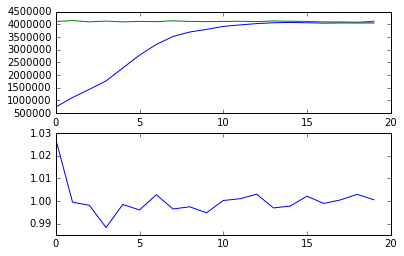

In [21]:
print pnom[1]

plt.subplot(211)
plt.plot(pnom.mean(axis=-1))
plt.plot(pdenom.mean(axis=-1))

P = (pnom.mean(-1) / pdenom.mean(-1))
Pmed = (np.median(pnom, axis=-1) / np.median(pdenom, axis=-1))
Pnoise = (pnom / pdenom).std(-1)

plt.subplot(212)

plt.plot(P / Pmed)
#lt.plot(Pmed)
print P.shape, len(SN)

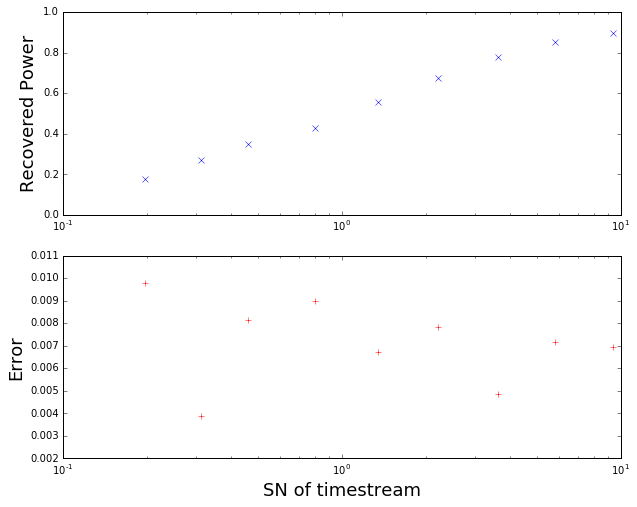

In [22]:
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(SN, P, 'bx')

plt.ylim(0,1)
plt.xscale('log')
plt.xlim(0.1,10)
plt.ylabel('Recovered Power', fontsize=18)

plt.subplot(212)
plt.plot(SN, Pnoise, 'r+')
#plt.ylim(0,0.1)
plt.xlim(0.1,10)

plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)

plt.xscale('log')

In [154]:
xtest = SN[1:]
ytest1 = P[1:]
ytest2 = Pnoise[1:]

z = np.polyfit(xtest, ytest1, 5)
#np.save('SNcorrectionPol.npy',z)
ptest1 = np.poly1d(z)

z = np.polyfit(xtest, ytest2, 5)
#np.save('SNnoisePol.npy',z)
ptest2 = np.poly1d(z)

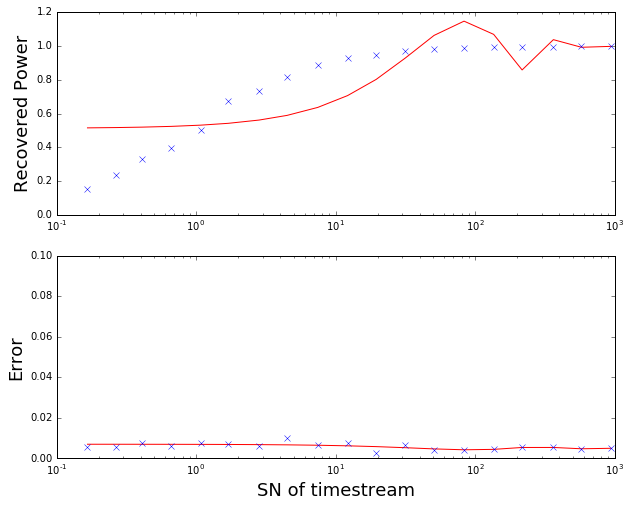

In [155]:
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(xtest, ptest1(xtest), 'r')
plt.plot(xtest, ytest1, 'bx')
plt.xscale('log')
plt.ylabel('Recovered Power', fontsize=18)

plt.subplot(212)
plt.plot(xtest, ptest2(xtest), 'r')
plt.plot(xtest, ytest2, 'bx')
plt.xscale('log')
plt.ylim(0,0.1)

plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)


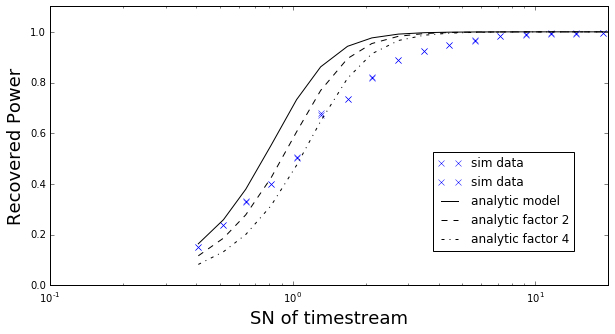

In [156]:
""" Add  """
def SNmodel(SN):
    return 1./np.sqrt(1+SN**(-2.0))

def SNmodel2(SN):
    return 1./np.sqrt(1+2*SN**(-2.0))

def SNmodel4(SN):
    return 1./np.sqrt(1+4*SN**(-2.0))

def SNmodel22(SN):
    return 1./np.sqrt(2+4*SN**(-2.0))

xtest = np.array(xtest)

xt = np.sqrt(xtest)

plt.figure(figsize=(10,5))

plt.plot(xt, ytest1, 'bx', label='sim data')
plt.plot(xt, Pmed[1:], 'bx', label='sim data')

#plt.plot( np.sqrt(xtest), ptest1(xtest), 'r', label='sim fit')

plt.plot(xt, SNmodel(np.array(xtest)), 'k', label='analytic model')
plt.plot(xt, SNmodel2(np.array(xtest)), 'k--', label='analytic factor 2')
plt.plot(xt, SNmodel4(np.array(xtest)), 'k-.', label='analytic factor 4')
plt.xscale('log')
plt.ylabel('Recovered Power', fontsize=18)

plt.xlim(0.1, 20)

plt.legend(bbox_to_anchor=(0.95, 0.5))

#plt.subplot(212)
#plt.plot(xtest, ptest2(xtest), 'r')
#plt.plot(xtest, ytest2, 'bx')
#plt.xscale('log')
plt.ylim(0,1.1)

#plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)


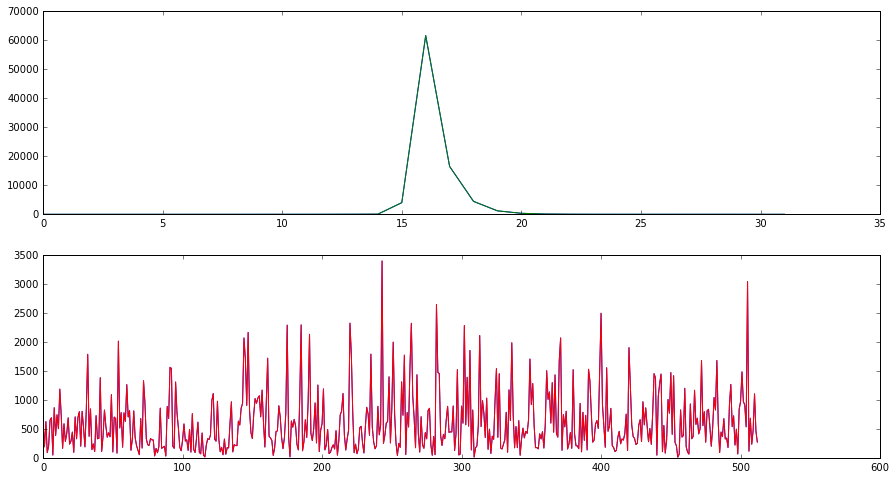

In [13]:
""" Check Correlation Coefficient Calculation """

length = 2**15
t = np.arange(length)
g = ( np.exp(-t / 390.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))

irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

pt1 = simGP(10, irf, 0)
pt2 = simGP(10, irf, 0)

p1chan = channelize_ts(pt1, 512)
p2chan = channelize_ts(pt2, 512)

plt.figure(figsize=(15,8))

plt.subplot(211)
plt.plot(abs(p1chan).sum(-1))
plt.plot(abs(p2chan).sum(-1))

#plt.xlim(70,85)

plt.subplot(212)
plt.plot((np.abs(p1chan)**2.0).mean(0))
plt.plot((np.abs(p2chan)**2.0).mean(0) , 'r')



1.0


/home/ramain/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt


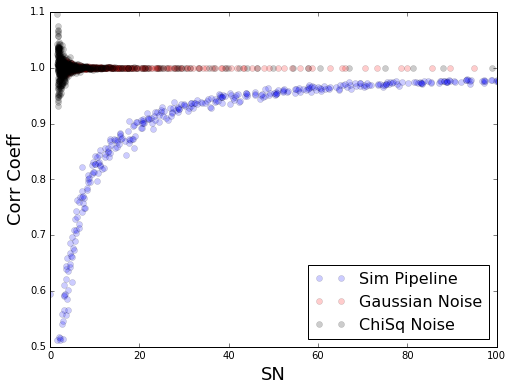

In [109]:
def ExtractPulse(x):
    
    pulse = x[16]
    noise = x[:10] #.mean(0)
    #bg = x[15:70]#.mean(0)

    GP = pulse #- bg
    n = noise #- bg

    return GP, noise

def CorrPulses(GP1, N1, GP2, N2):
    autoc = (GP1 - np.mean(GP1))  * (GP2 - np.mean(GP2))

    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    #std1 = np.std(GP1)**2.0 #- np.mean(N1**2.0)
    #std2 = np.std(GP2)**2.0 #- np.mean(N2**2.0)
    
    corr = np.mean(autoc) / np.sqrt(std1 * std2)
    return corr

Carray = []
Cgauss = []
CX = []
SN1 = []
SN2 = []
SN3 = []

N = 500

for i in range(N):
    pt1 = simGP(30.*i/N, irf, 1)
    pt2 = simGP(30.*i/N, irf, 1)

    p1chan = channelize_ts(pt1, 512)
    p2chan = channelize_ts(pt2, 512)
    
    GP1, N1 = ExtractPulse(np.abs(p1chan)**2.0)
    GP2, N2 = ExtractPulse(np.abs(p2chan)**2.0)

    SN1.append((GP1.mean() - N1.mean())/N1.std())
    
    cc = CorrPulses(GP1[1:-1], N1[1:-1], GP2[1:-1], N2[1:-1])
    Carray.append(cc)
    
    if i == 0:
        AutoTest = CorrPulses(GP1, 0, GP1, 0)
        print AutoTest
    
for i in range(N):
    ptg = simGP(3, irf, 0)
    pgchan = channelize_ts(ptg, 512)
    G1 = np.abs(pgchan)**2.0 + np.random.normal(scale=i+1, size=pgchan.shape)
    G2 = np.abs(pgchan)**2.0 + np.random.normal(scale=i+1, size=pgchan.shape)
    
    GaussGP1, GaussN1 = ExtractPulse(G1)
    GaussGP2, GaussN2 = ExtractPulse(G2)

    ccgauss = CorrPulses(GaussGP1, GaussN1, GaussGP2, GaussN2)
    Cgauss.append(ccgauss)
    SN2.append((GaussGP1.mean() - GaussN1.mean())/ GaussN1.std())

for i in range(N):
    ptX = simGP(3, irf, 0)
    pXchan = channelize_ts(ptX, 512)
    G1 = np.abs(pXchan)**2.0 + i*np.random.chisquare(df=2, size=pgchan.shape)
    G2 = np.abs(pXchan)**2.0 + i*np.random.chisquare(df=2, size=pgchan.shape)
    
    XGP1, XN1 = ExtractPulse(G1)
    XGP2, XN2 = ExtractPulse(G2)

    ccX = CorrPulses(XGP1, XN1, XGP2, XN2)
    CX.append(ccX)
    SN3.append((XGP1.mean() - XN1.mean())/ XN1.std())
    
plt.figure(figsize=(8,6))
plt.ylim(0.5, 1.1)
plt.xlim(0,100)

plt.plot(SN1, Carray, 'bo', alpha=0.2, label='Sim Pipeline')
plt.plot(SN2, Cgauss, 'ro', alpha=0.2, label='Gaussian Noise')
plt.plot(SN3, CX, 'ko', alpha=0.2, label='ChiSq Noise')

plt.xlabel('SN', fontsize=18)
plt.ylabel('Corr Coeff', fontsize=18)

plt.legend(fontsize=16, loc=4)


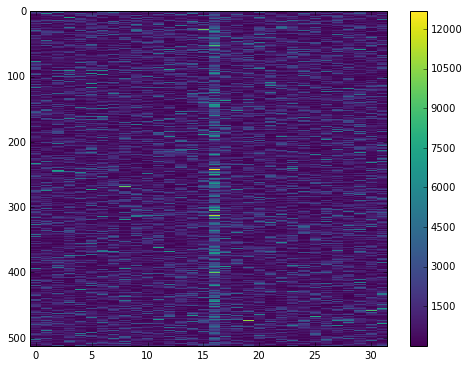

In [101]:
plt.figure(figsize=(8,6))

plt.imshow( G1.T, cmap=cm.viridis, aspect='auto', interpolation='nearest')
plt.colorbar()
#plt.plot(N1)

0.495030329349


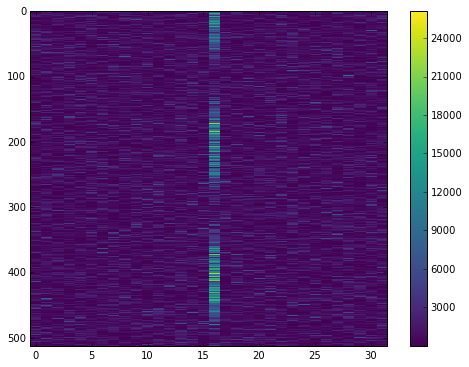

In [107]:
plt.figure(figsize=(8,6))

ts_noise1 = np.random.normal(size=length)
ts_noise1[length//2] += 50
ts_noise1[length//2 + 5] += 50
ft_noise1 = np.fft.rfft(ts_noise1.reshape(-1, 1024), axis=-1)
power_noise1 = (abs(ft_noise1)**2.0)

ts_noise2 = np.random.normal(size=length)
ts_noise2[length//2] += 50
ts_noise2[length//2 + 5] += 50
ft_noise2 = np.fft.rfft(ts_noise2.reshape(-1, 1024), axis=-1)
power_noise2 = (abs(ft_noise2)**2.0)

g1, n1 = ExtractPulse(power_noise1)
g2, n2 = ExtractPulse(power_noise2)

ctest = CorrPulses(g1, n1, g2, n2)
print ctest

plt.imshow(power_noise1.T, aspect='auto', interpolation='nearest', cmap=cm.viridis)
plt.colorbar()